# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [18]:
import sqlite3
from sqlite3 import Error

db_file = "/Users/KathrynChiang/Downloads/sf_data.sqlite"

conn = sqlite3.connect(db_file)
c = conn.cursor()
c.execute('PRAGMA table_info(mobile_food_schedule)')
c.fetchall()
c.execute('PRAGMA table_info(mobile_food_permits)')
c.fetchall()
c.execute('SELECT COUNT(DISTINCT locationid), mfp.Applicant FROM mobile_food_schedule mfs, mobile_food_permits mfp WHERE mfs.permit = mfp.permit GROUP BY mfs.permit ORDER BY COUNT(locationid) DESC LIMIT 1')
r = c.fetchall()
print r

[(58, u'May Catering')]


<p> May Catering sells at the most locations with 58 different locations.</p>

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
from nltk.probability import FreqDist
from matplotlib.patches import Polygon

def get_list(dat,col):
    """input: data and column number"""
    x = []
    for i in range(len(dat)):
        x.append(dat[i][col])
    return x
def get_date(x):
    """output: split date to year-month"""
    month = []
    mlist = get_list(x,0)
    for i in range(len(x)):
        m = str(mlist[i])
        month.append(m.split()[0][0:7])
    return month

<h3>Which mobile food vendor has the most parking capacity?</h3>

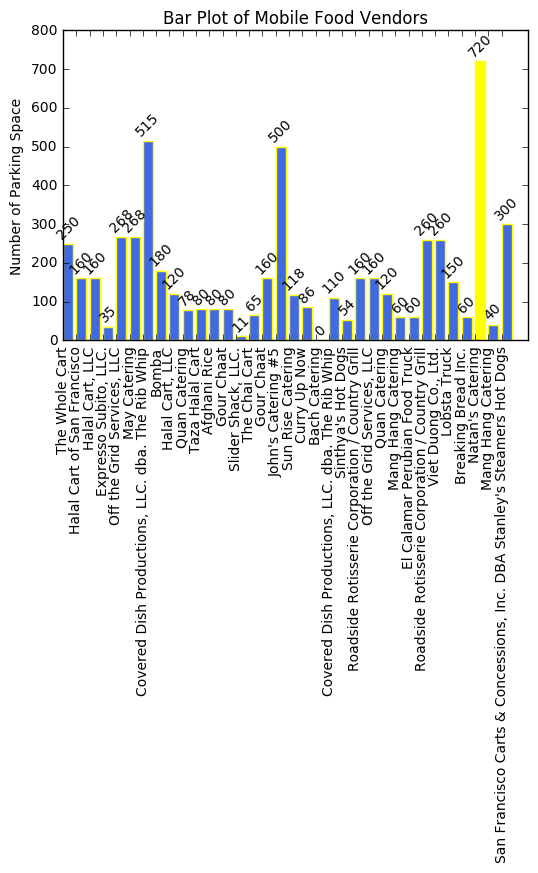

[(u"Natan's Catering", 720)]

In [20]:
c.execute('SELECT DISTINCT mfp.applicant, parking.regcap FROM parking, mobile_food_locations mfl, mobile_food_schedule mfs, mobile_food_permits mfp WHERE parking.address = mfl.address AND mfl.locationid = mfs.locationid AND mfs.permit = mfp.permit')
dat = c.fetchall()
l = range(len(dat))
lab = get_list(dat,0)
width = 0.75
val = get_list(dat,1)
fig,ax = plt.subplots()
rects = ax.patches
bar = plt.bar(l,val,width,color='royalblue',edgecolor='yellow')
bar[-3].set_color('yellow')
plt.xticks(l, lab, rotation = 90)
plt.ylabel('Number of Parking Space')
plt.title('Bar Plot of Mobile Food Vendors')
labels = val
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',rotation = 45)
plt.show()
c.execute('SELECT DISTINCT mfp.applicant, parking.regcap FROM parking, mobile_food_locations mfl, mobile_food_schedule mfs, mobile_food_permits mfp WHERE parking.address = mfl.address AND mfl.locationid = mfs.locationid AND mfs.permit = mfp.permit ORDER BY parking.regcap DESC LIMIT 1')
c.fetchall()

<p>This is a bar plot with mobile food vendor names and number of parking space in their parking lot. Natan's Catering (yellow bar) seems to have the most parking capacity of 720 spaces. How do I got this answer? I first link the parking lot address to mobile food location address, so we know which vendors have parking lot. Then I order the dataset by parking space numbers in descending order, so the last value will has the max parking space number.</p>

<h3>Which month of the year gets the most noise complaints? Which month of the year gets the least noise complaints?</h3>

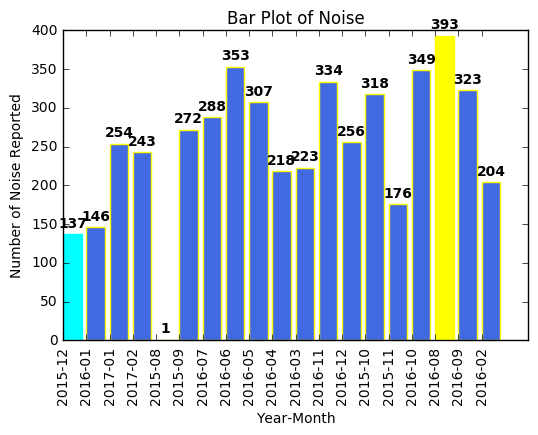

In [21]:
c.execute('SELECT datetime FROM noise')
x = c.fetchall()
ym = get_date(x)
fdist = FreqDist(ym)
y = fdist.values()
lab = fdist.keys()
l = range(len(y))
fig,ax = plt.subplots()
rects = ax.patches
bar = plt.bar(l,y,color = 'royalblue',edgecolor='yellow')
bar[-3].set_color('yellow')
bar[0].set_color('aqua')
plt.xticks(l,lab,rotation = 90)
plt.ylabel('Number of Noise Reported')
plt.xlabel('Year-Month')
plt.title('Bar Plot of Noise')
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',fontweight='bold')
plt.show()

<p>Auguest 2016 (yellow bar) has the most noise complaints of 393 reports, and December 2015 (light blue bar) has the least noise complaints of 137 reports. How do I get this answer? First, I split the date and time and extract the year-month out of the dataset. Then, I count the frequencies for the months and using bar plot to visualize the results. Augest 2015 seems to have the least noise report. However, since it does not contain the full datset for Augest 2015, it does not count into our consideration.</p>

<h3>Is there any relationship between the school locations and noise complaints?</h3>


In [22]:
c.execute('SELECT lat, lon FROM schools')
dat = c.fetchall()
lat_s = get_list(dat,0)
lat_s = [x for x in lat_s if x is not None]
lon_s = get_list(dat,1)
lon_s = [x for x in lon_s if x is not None]
c.execute('SELECT lat, lon FROM noise')
data = c.fetchall()
lat_n = get_list(data,0)
lat_n = [x for x in lat_n if x is not None]
lon_n = get_list(data,1)
lon_n = [x for x in lon_n if x is not None]

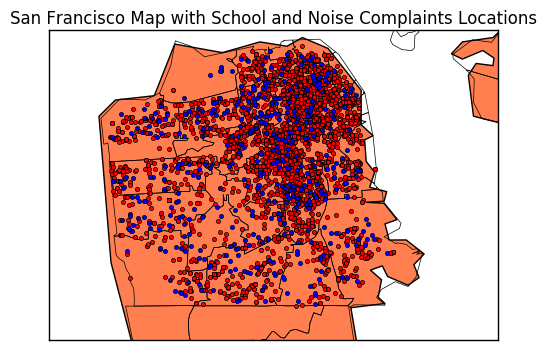

In [23]:
map = Basemap(resolution='h', projection='merc',# area_thresh = 1000.0,
              lat_0=57, lon_0=-135,
              llcrnrlat=37.695,urcrnrlat=37.815,
              llcrnrlon=-122.54,urcrnrlon=-122.32)

map.drawmapboundary()
map.fillcontinents(color='coral')
map.drawcoastlines()
map.readshapefile('/Users/KathrynChiang/Downloads/cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k', 'comarques')

latn = lat_n
lonn = lon_n
for lon, lat in zip(lonn, latn):
    x,y = map(lon, lat)
    map.plot(x, y, 'ro', markersize=3)
lats = lat_s
lons = lon_s
for lon, lat in zip(lons, lats):
    x,y = map(lon, lat)
    map.plot(x, y, 'bo', markersize=3)

plt.title('San Francisco Map with School and Noise Complaints Locations')
plt.show()

<p>I expected there is a relationship between school location and noise complaints location, since students sometimes gets a little noisy especially with a groups that have the same ages. Not too surprisingly, By looking at the basemap for the location of schools (blue dots) and noise complaints (red dots), there seems to have a relationship between school locations and noise complaints becuase most of the blue dots are near or overlap with red dots.</p>

<h3>Is there any relationship between mobile food locations and school locations?</h3>

In [24]:
c.execute('SELECT latitude, longitude FROM mobile_food_locations')
dat = c.fetchall()
lat_m = get_list(dat,0)
lat_m = [x for x in lat_m if x is not None]
lon_m = get_list(dat,1)
lon_m = [x for x in lon_m if x is not None]

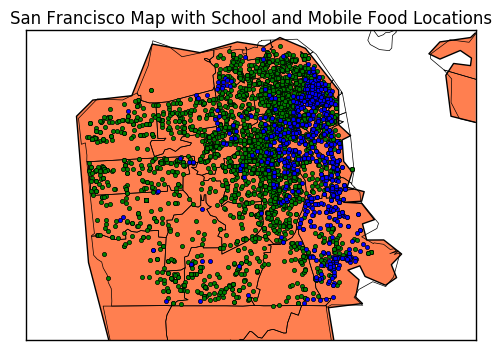

In [28]:
map = Basemap(resolution='h', projection='merc',# area_thresh = 1000.0,
              lat_0=57, lon_0=-135,
              llcrnrlat=37.695,urcrnrlat=37.815,
              llcrnrlon=-122.54,urcrnrlon=-122.32)

map.drawmapboundary()
map.fillcontinents(color='coral')
map.drawcoastlines()
map.readshapefile('/Users/KathrynChiang/Downloads/cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k', 'comarques')

latn = lat_n
lonn = lon_n
for lon, lat in zip(lonn, latn):
    x,y = map(lon, lat)
    map.plot(x, y, 'go', markersize=3)
lats = lat_m
lons = lon_m
for lon, lat in zip(lons, lats):
    x,y = map(lon, lat)
    map.plot(x, y, 'bo', markersize=3)
plt.title('San Francisco Map with School and Mobile Food Locations')
plt.show()

<p>I expected there is a relationship between location for schools and locations for mobile food, since resturants will open in areas where have a lot of people, so they can earn money from them. However, after graph out the locations for schools and mobile food, there does not seems to have a relationship between them. Some school locations (blue points) on the lower right seems to have no correlation with mobile food locations at all, so we can conclude that there is a weak relationship between location for schools and locations for mobile food.</p>

<h3>What time in San Francisco is the most dangerous?</h3>

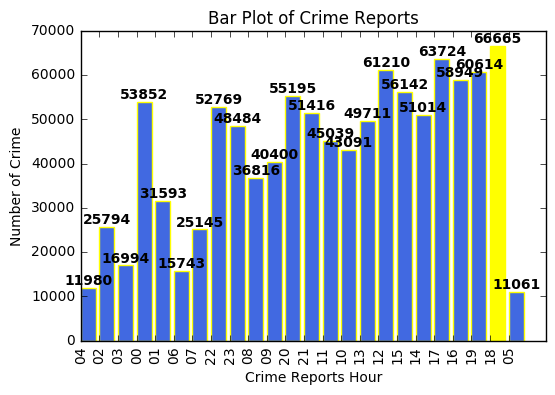

In [26]:
c.execute('SELECT datetime FROM crime')
x = c.fetchall()
def get_hr(x):
    """output: split time to hour"""
    hr = []
    mlist = get_list(x,0)
    for i in range(len(x)):
        m = str(mlist[i])
        hr.append(m.split()[1].split(':')[0])
    return hr

ym = get_hr(x)
fdist = FreqDist(ym)
y = fdist.values()
lab = fdist.keys()
l = range(len(y))
fig,ax = plt.subplots()
rects = ax.patches
bar = plt.bar(l,y,color = 'royalblue',edgecolor='yellow')
bar[-2].set_color('yellow')

plt.xticks(l,lab,rotation = 90)
plt.ylabel('Number of Crime')
plt.xlabel('Crime Reports Hour')
plt.title('Bar Plot of Crime Reports')
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',fontweight='bold')
plt.show()

<p>Eighteen o'clock (yellow bar) is the most dangerous hour in San Francisco that has the most crime reports during this hour. How do I get this answer? First, I split the datetime column and extract only the hour out for each crime report. Then, I count hour of frequencies that crime reported happened. Eighteen o'clock seems to have the most reports of 66665 reports.</p>